In [1]:
from __future__ import print_function
import os
import inspect

import numpy as np
import pandas as pd

import pdNLS
from pdNLS import exponential_decay

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('ticks')

%matplotlib inline

In [2]:
# This will download the demonstration data for those who want to run the demo
import requests

r = requests.get('https://raw.githubusercontent.com/mlgill/pdNLS/master/pdNLS/demo/GCN4_twofield.csv')

with open('GCN4_twofield.csv', 'w') as fh:
    fh.write(r.text)

## Overview

`pdNLS` is a library for performing non-linear least squares (NLS) minimization. It attempts to seamlessly incorporate this task in a Pandas-focused workflow. Input data are expected in dataframes, and multiple regressions can be performed using functionality similar to Pandas `groupby`. Results are returned as grouped dataframes and include best-fit parameters, statistics, residuals, and more. The results can be easily visualized using [`seaborn`](https://github.com/mwaskom/seaborn).

`pdNLS` is related to libraries such as [`statsmodels`](http://statsmodels.sourceforge.net) and [`scikit-learn`](http://scikit-learn.org/stable/) that provide linear regression functions that operate on dataframes. As I was unable to find any that perform non-linear regression, I developed `pdNLS` to fill this niche. 

`pdNLS` utilizes [`lmfit`](https://github.com/lmfit/lmfit-py), a flexible and powerful library for non-linear least squares minimization, which in turn, makes use of `scipy.optimize.leastsq`. I began using `lmfit` several years ago because I like the flexibility it offers for testing different modeling scenarios and the variety of assessment statistics it provides. However, I found myself writing many `for` loops to perform regressions on groups of data and aggregate the resulting output.

Some additional 'niceties' associated with the input of parameters and equations have also been incorporated. `pdNLS` also utilizes multithreading for the calculation of confidence intervals, as this process is time consuming when there are more than a few groups.

## Minimization setup

To understand `pdNLS`, we will be using some sample scientific data. This data is nuclear magnetic resonance (NMR) data acquired at two different magnetic field strengths (14.1 and 21.1 T) on an enzyme called GCN4. 

There are six amino acids in the enclosed data set, so using amino acid residue (`resi`) and magnetic field (`field`) as the `groupby` columns results in 12 minimization operations.

In [3]:
! head GCN4_twofield.csv
data = pd.read_csv('GCN4_twofield.csv', sep='\t')

resi	field	time	intensity
51	14.1	0.004	1624.219428
51	14.1	0.008	1491.46728
51	14.1	0.024	1022.717456
51	14.1	0.064	448.038543
51	14.1	0.096	270.116745
51	14.1	0.144	148.671651
51	14.1	0.208	103.322608
52	14.1	0.004	1614.38584
52	14.1	0.008	1500.47205


We will be analyzing this data to determine the rate of exponential decay as a function of time for every amino acid residue at each of two magnetic field strengths. The equation looks like this:

$I_{(t)} = I_{(0)} \space e^{(-R * t)}$  

where $I_{(0)}$ is the initial intensity, $I_{(t)}$ is the intensity at time $t$, and $R$ is the exponential decay  rate. 

## Regression and prediction

Parameters for `pdNLS` are entered as a list of dictionaries with the format being similar to that used by [`lmfit`](https://lmfit.github.io/lmfit-py/parameters.html).

Performing the regression is quite simple--just call the class `pdNLS` with input parameters set. The `fit` method performs the regression and `predict` calculates a best-fit line at higher resolution for plotting.

*TODO: update when I fix the bug in the predict method*

In [5]:
params = [{'name':'inten', 
           'value':np.asarray(data.groupby(['resi', 'field']).intensity.max()), 
           'vary':True},
          {'name':'rate', 
           'value':20.0, 
           'vary':True}]

fit_data = pdNLS.pdNLS(data, exponential_decay, 
                       ['resi', 'field'], params, 
                       'time', 'intensity')
fit_data.fit()
# fit_data.predict()

## Results

From these simple commands, four output tables are created:

* **data** for the input data, calculated data, and residuals
* **results**, which contains the best-fit parameters and estimations of their error
* **stats** for statistics related to the regression, such as chi-squared and AIC
* **model**, which contains a best-fit line created by the `predict` method

Let's take a look at a couple of these tables. The **results** table contains best-fit parameters, their standard errors, and confidence intervals.

In [17]:
fit_data.results.head(n=4)

inten                                 rate            \
                   value       stderr       ci0.95      value    stderr   
resi field                                                                
51   14.1    1714.801224    37.873598    58.412803  19.650244  1.017596   
     21.1   61172.422208  2056.605717  3233.839208  21.244426  1.632509   
52   14.1    1778.899941    17.866286    32.098115  23.354822  0.487731   
     21.1   72392.056557   511.164845   899.609872  32.172892  0.899967   

                      
              ci0.95  
resi field            
51   14.1   1.737309  
     21.1   2.747193  
52   14.1   0.961983  
     21.1   1.359184

The **stats** table contains the following statistics for each of the regression groups:

* Number of observations (`nobs`)
* Number of fit parameters (`npar`)
* Degrees of freedom (`dof`)
* Chi-squared (`chisqr`)
* Reduced chi-squared (`redchi`)
* Akaike information criterion (`aic`)
* Bayesian information criterion (`bic`)
* Covariance matrix (`covar`)

In [16]:
fit_data.stats.head(n=4)

nobs  npar  dof        chisqr        redchi         aic  \
resi field                                                            
51   14.1      7     2    5  4.618933e+07  9.237866e+06  116.271750   
     21.1      7     2    5  3.867213e+14  7.734425e+13  227.855012   
52   14.1      7     2    5  2.013268e+06  4.026536e+05   94.340823   
     21.1      7     2    5  2.469331e+12  4.938662e+11  192.478713   

                   bic                                              covar  
resi field                                                                 
51   14.1   116.163570  [[1434.40941598, 25.1920994106], [25.192099410...  
     21.1   227.746832  [[4229627.07654, 2206.79019345], [2206.7901934...  
52   14.1    94.232643  [[319.204188624, 6.64745810301], [6.6474581030...  
     21.1   192.370534  [[261289.498533, 362.755226131], [362.75522613...

It is also easy to access a single covariance matrix for calculations.

In [9]:
fit_data.stats.covar.loc[(resi, field)]

array([[  4.22962708e+06,   2.20679019e+03],
       [  2.20679019e+03,   2.66508651e+00]])

## Visualization

The results can be visualized in facet plots with Seaborn. To make it easier to view the data, all intensities have been normalized.  

*TODO: best-fit line will be added when `predict` method is fixed.*

In [10]:
fit_itensities = (fit_data.results
                  .loc[:,('inten','value')]
                  .to_frame()
                  )

fit_itensities.columns=['inten_fit']

In [11]:
fit_data.data = pd.merge(fit_data.data,
                         fit_itensities,
                         left_index=True,
                         right_index=True,
                         how='left'
                        )

fit_data.data['intensity'] /= fit_data.data.inten_fit
#fit_data.data['ycalc'] /= fit_data.data.inten_fit

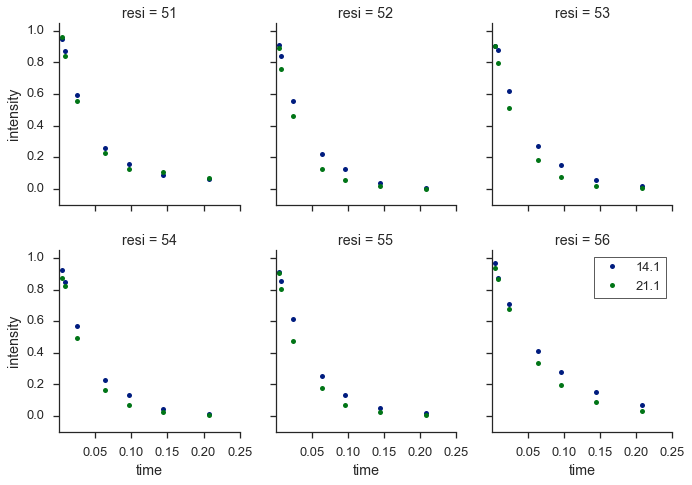

In [12]:
plot_data = fit_data.data.reset_index()

grid = sns.FacetGrid(plot_data, col='resi', hue='field', #palette=palette,
                     col_wrap=3, size=2.0, aspect=0.75, 
                     sharey=True, despine=True)

# grid.map(plt.plot, 'time', 'ycalc', marker='', ls='-')
grid.map(plt.plot, 'time', 'intensity', marker='o', ms=5, ls='')

grid.set(xticks=np.linspace(0.05, 0.25, 5),
         ylim=(-0.1, 1.05))

legend = grid.axes[-1].legend(loc=0, frameon=True)
legend.get_frame().set_linewidth(0.75)

f = plt.gcf()
f.set_size_inches(12,8)
f.subplots_adjust(wspace=0.2, hspace=0.25)

Just for fun, here's a bar graph of the decay rates determined from NLS.

*TODO: could probably remove the plot below since this post is long.*

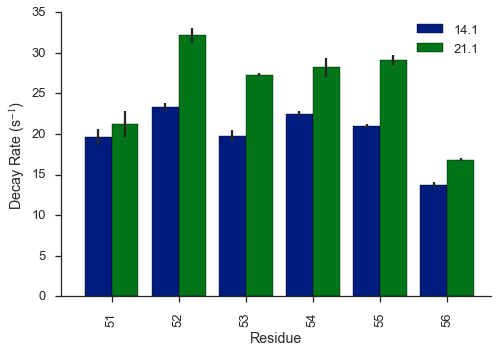

In [13]:
plot_data = (fit_data.results
             .sort_index(axis=1)
             .loc[:,('rate',['value','stderr'])]
             )
plot_data.columns = plot_data.columns.droplevel(0)
plot_data.reset_index(inplace=True)

fig = plt.figure()
fig.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for pos, (field, dat) in enumerate(plot_data.groupby('field')):
    _ = dat.plot('resi', 'value', yerr='stderr',
                 kind='bar', label=field, color=colors[pos],
                 position=(-pos)+1, ax=ax, width=0.4)
    
ax.set_ylabel('Decay Rate (s$^{-1}$)')
ax.set_xlabel('Residue')
ax.set_xlim(ax.get_xlim()[0]-0.5, ax.get_xlim()[1])

sns.despine()
plt.tight_layout()

In [14]:
! rm ./GCN4_twofield.csv